# 프로젝트: Mixup 또는 CutMix 비교실험 하기
## 프로젝트 제출 루브릭

| 평가 기준 | 달성 여부 및 설명 |
|-----------|--------------------|
| MixUp과 CutMix 기법을 ResNet50 분류기에 성공적으로 적용하였는가? | MixUp과 CutMix를 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 안정적으로 수렴하였다. |
| 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가? | 각 Augmentation 기법 적용 후 성능 비교, 문제점 분석을 수행하여 최적 기법을 도출하였다. |
| 여러 가지 Augmentation 기법 적용 결과를 체계적으로 비교·분석하였는가? | 기본 Augmentation, MixUp, CutMix 결과를 시각화하고 해석을 포함해 체계적으로 분석하였다. |

# Data & Library

In [4]:
!wget "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar" -P ~/work/project/GoingDeeper/Quest02/data 
!tar -xf ~/work/project/GoingDeeper/Quest02/data/images.tar -C ~/work/project/GoingDeeper/Quest02/data/
!rm -rf ~/work/project/GoingDeeper/Quest02/data/images.tar

--2025-11-14 14:27:35--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘/home/jovyan/work/project/GoingDeeper/Quest02/data/images.tar’

images.tar          100%[===================>] 756.82M  18.9MB/s    in 67s     

2025-11-14 14:28:43 (11.3 MB/s) - ‘/home/jovyan/work/project/GoingDeeper/Quest02/data/images.tar’ saved [793579520/793579520]



In [18]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset, Subset

import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

dataset_dir = "data/Images/"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


# Augmentation을 적용한 데이터셋 만들기

## CutMix

In [19]:
def get_clip_box(image_a, image_b):
    # image.shape = (channel, height, width)
    image_size_x = image_a.shape[2]  # Width
    image_size_y = image_a.shape[1]  # Height

    # Get center of box
    x = torch.randint(0, image_size_x, (1,)).item()
    y = torch.randint(0, image_size_y, (1,)).item()

    # Alpha(1.0)를 사용한 비율 람다를 구하는 대신, 바운딩 박스 크기를 랜덤하게 설정
    # 원 코드와 동일한 방식으로 비율을 계산합니다.
    width = max(1, int(image_size_x * torch.sqrt(1 - torch.rand(1)).item()))
    height = max(1, int(image_size_y * torch.sqrt(1 - torch.rand(1)).item()))

    # Clip box in image and get minmax bbox
    x_min = max(0, x - width // 2)
    y_min = max(0, y - height // 2)
    x_max = min(image_size_x, x + width // 2 + 1)
    y_max = min(image_size_y, y + height // 2 + 1)

    return x_min, y_min, x_max, y_max

def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    # image.shape = (C, H, W)
    
    mixed_img = image_a.clone()
    # image_b의 중앙 부분을 image_a에 붙여넣습니다.
    mixed_img[:, y_min:y_max, x_min:x_max] = image_b[:, y_min:y_max, x_min:x_max]
    
    return mixed_img

def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes):
    image_size_x = 224 # 하드 코딩 대신 배치 이미지의 크기를 사용해야 하나, 여기서는 224로 가정
    image_size_y = 224 # (image_a.shape[2], image_a.shape[1] 대신 고정 크기 사용)

    # 바운딩 박스 비율 계산 (lambda)
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = image_size_x * image_size_y
    ratio = mixed_area / total_area

    # 원-핫 벡터 변환은 호출하는 cutmix 함수에서 처리합니다.
    mixed_label = (1 - ratio) * label_a + ratio * label_b
    return mixed_label

In [20]:
def cutmix(images, labels, batch_size, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    # labels는 Hard Label (int Tensor)로 가정하고 One-Hot Encoding을 여기서 수행합니다.
    labels_onehot = F.one_hot(labels, num_classes=num_classes).float().to(images.device)
    
    # 배치 내에서 섞을 랜덤 인덱스
    indices = torch.randperm(batch_size).to(images.device) 
    images_b = images[indices]
    labels_b = labels_onehot[indices]

    for i in range(batch_size):
        image_a = images[i]
        label_a = labels_onehot[i]
        
        # 바운딩 박스 생성
        # images_b[i]를 사용해야 배치 내 다른 이미지와 섞입니다.
        x_min, y_min, x_max, y_max = get_clip_box(image_a, images_b[i]) 

        # 이미지 섞기
        mixed_img = mix_2_images(image_a, images_b[i], x_min, y_min, x_max, y_max)
        
        # 라벨 섞기
        mixed_label = mix_2_labels(label_a, labels_b[i], x_min, y_min, x_max, y_max, num_classes)
        
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    # 텐서 변환 및 배치 차원 복구
    mixed_imgs = torch.stack(mixed_imgs).reshape(batch_size, 3, img_size, img_size)
    mixed_labels = torch.stack(mixed_labels).reshape(batch_size, num_classes)

    return mixed_imgs, mixed_labels

## MixUp

In [21]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    # Beta 분포 (alpha=1.0) 대신 0~1 사이의 균일 분포 사용 (원 코드와 동일)
    ratio = torch.rand(1).item() 

    # 이미지와 라벨 혼합
    mixed_image = (1 - ratio) * image_a + ratio * image_b
    mixed_label = (1 - ratio) * label_a + ratio * label_b

    return mixed_image, mixed_label

In [22]:
def mixup(images, labels, batch_size, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    
    # labels는 Hard Label (int Tensor)로 가정하고 One-Hot Encoding을 여기서 수행합니다.
    labels_onehot = F.one_hot(labels, num_classes=num_classes).float().to(images.device)
    
    # 배치 내에서 섞을 랜덤 인덱스
    indices = torch.randperm(batch_size).to(images.device)
    images_b = images[indices]
    labels_b = labels_onehot[indices]
    
    for i in range(batch_size):
        image_a = images[i]
        label_a = labels_onehot[i]
        
        # Mixup 적용
        mixed_img, mixed_label = mixup_2_images(image_a, images_b[i], label_a, labels_b[i])

        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    # 배치 차원 추가
    mixed_imgs = torch.stack(mixed_imgs).view(batch_size, 3, img_size, img_size)
    mixed_labels = torch.stack(mixed_labels).view(batch_size, num_classes)

    return mixed_imgs, mixed_labels

## Augmentation

In [23]:
def get_base_train_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),

        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2),
        transforms.Lambda(lambda img: torch.clamp(img, 0, 1)), # 값 클리핑

        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

## Dataset Load & Split

In [24]:
# No Aug, Validation, Test용
def get_base_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# One-Hot Encoding 함수 (Validation Loss 계산 시 Hard Label을 사용할 것이므로 그대로 유지)
def onehot(label, num_classes=120):
    if not isinstance(label, torch.Tensor):
        label = torch.tensor(label)
    # 이미 one-hot된 형태일 경우 패스 (MixUp/CutMix의 Soft Label)
    if label.dim() > 1 and label.dtype == torch.float: 
        return label
    return torch.nn.functional.one_hot(label, num_classes=num_classes).float()

In [25]:
full_dataset = ImageFolder(root=dataset_dir, transform=None) # Transform은 DataLoader에서 적용
global num_classes
num_classes = len(full_dataset.classes)

total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_subset_indices, val_subset_indices, test_subset_indices = random_split(
    range(total_size),
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Total images: {total_size}, Number of classes: {num_classes}")
print(f"Train: {train_size}, Validation: {val_size}, Test: {test_size}")

Total images: 20580, Number of classes: 120
Train: 16464, Validation: 2058, Test: 2058


# 모델 만들기


## DataLoder 4가지 준비
- Aug 없는 비교군
- Aug 있는 실험군
- MixUp 실험군
- CutMix 실험군

In [26]:
BATCH_SIZE = 32

class CustomSubset(Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __getitem__(self, idx):
        image, label = self.dataset[self.indices[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.indices)

# 각 훈련 조건별 데이터셋 준비
# 1. No Aug (Normalization만)
ds_train_no_aug_set = CustomSubset(full_dataset, train_subset_indices.indices, transform=get_base_transform())
ds_train_no_aug_loader = DataLoader(ds_train_no_aug_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

# 2. Base Aug 
ds_train_aug_set = CustomSubset(full_dataset, train_subset_indices.indices, transform=get_base_train_transform())
ds_train_aug_loader = DataLoader(ds_train_aug_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

# 3 & 4. MixUp & CutMix 
ds_train_mix_cut_set = CustomSubset(full_dataset, train_subset_indices.indices, transform=get_base_transform())
ds_train_mixup_loader = DataLoader(ds_train_mix_cut_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
ds_train_cutmix_loader = DataLoader(ds_train_mix_cut_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

# 5. Validation/Test 
ds_val_set = CustomSubset(full_dataset, val_subset_indices.indices, transform=get_base_transform())
ds_test_set = CustomSubset(full_dataset, test_subset_indices.indices, transform=get_base_transform())
ds_val_loader = DataLoader(ds_val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
ds_test_loader = DataLoader(ds_test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

## ResNet 준비

In [27]:
# Augmentation 없는 기본 모델
model_no_aug = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model_no_aug.fc = nn.Linear(model_no_aug.fc.in_features, num_classes)

# 기본 Augmentation 적용 모델
model_aug = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model_aug.fc = nn.Linear(model_aug.fc.in_features, num_classes)

# MixUp 적용 모델
model_mixup = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model_mixup.fc = nn.Linear(model_mixup.fc.in_features, num_classes)

# CutMix 적용 모델
model_cutmix = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model_cutmix.fc = nn.Linear(model_cutmix.fc.in_features, num_classes)

# 모델 훈련하기

In [28]:
import time 
import os

criterion_val = nn.CrossEntropyLoss()

def soft_cross_entropy(outputs, labels):
    log_probs = F.log_softmax(outputs, dim=1)
    return -(log_probs * labels).sum(dim=1).mean()


def train(model, train_loader, val_loader, epochs, aug_type='no_aug', checkpoint_path=None):
    save_dir = 'model'
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Directory '{save_dir}' created.")

    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

    model.to(device)
    history = {
        'train_loss': [], 
        'train_accuracy': [], 
        'val_loss': [], 
        'val_accuracy': [],
        'epoch_time': [] 
    }

    # --------------------- 학습 재개 로직 ---------------------
    if checkpoint_path and os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}...")
        try:
            checkpoint = torch.load(checkpoint_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch'] + 1 
            history.update(checkpoint['history']) 
            print(f"Training resumed from Epoch {start_epoch}")
        except Exception as e:
            print(f"Error loading checkpoint: {e}. Starting training from scratch.")
            start_epoch = 0 
    # -----------------------------------------------------------------
    
    for epoch in range(epochs):

        start_time = time.time() 

        model.train()
        correct = 0
        total = 0
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Augmentation 적용 (배치 단위)
            # 이전에 모델 학습 전에, 전부 적용하게 되면 memory 용량 초과로 다운되는 현상으로
            # 학습에서 배치가 들어올때마다, 그 배치 내에서 적용하고 학습 돌리는 방향으로 변경
            if aug_type == 'cutmix':
                images, labels_soft = cutmix(images, labels, batch_size=images.size(0), num_classes=num_classes)
            elif aug_type == 'mixup':
                images, labels_soft = mixup(images, labels, batch_size=images.size(0), num_classes=num_classes)
            else:
                labels_soft = onehot(labels, num_classes=num_classes).to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = soft_cross_entropy(outputs, labels_soft)
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            _, predicted = outputs.max(1)
            _, hard_labels = labels_soft.max(1) 
            total += hard_labels.size(0)
            correct += predicted.eq(hard_labels).sum().item()
            

        epoch_train_loss = running_loss / total
        train_acc = 100. * correct / total
        history['train_loss'].append(epoch_train_loss)
        history['train_accuracy'].append(train_acc)

        model.eval()
        correct_val = 0
        total_val = 0
        running_loss_val = 0.0
        
        with torch.no_grad():
            for images_val, labels_val in val_loader:
                images_val, labels_val = images_val.to(device), labels_val.to(device)
                
                hard_labels_val = labels_val
                
                outputs_val = model(images_val)
                loss_val = criterion_val(outputs_val, hard_labels_val)
                
                running_loss_val += loss_val.item() * images_val.size(0)
                
                _, predicted_val = outputs_val.max(1)
                total_val += hard_labels_val.size(0)
                correct_val += predicted_val.eq(hard_labels_val).sum().item()

        epoch_val_loss = running_loss_val / total_val
        val_acc = 100. * correct_val / total_val
        history['val_loss'].append(epoch_val_loss)
        history['val_accuracy'].append(val_acc)
        

        end_time = time.time()
        epoch_duration = end_time - start_time
        history['epoch_time'].append(epoch_duration) 
        
        print(f"Epoch [{epoch+1}/{epochs}] ({aug_type.upper()}) | Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {epoch_val_loss:.4f}, Val Acc: {val_acc:.2f}% | Time: {epoch_duration/60:.2f}분")

        # --------------------- 체크포인트 저장 로직 ---------------------
        # 매 에포크마다 현재 상태 저장
        current_checkpoint_path = f'{save_dir}/{aug_type}_checkpoint_latest.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history
        }, current_checkpoint_path)
        # ----------------------------------------------------------------------
        
    return history

In [30]:
EPOCH = 50

# Augmentation 없는 기본 모델 훈련
print("\n--- 1. NO AUGMENTATION ---")
history_no_aug = train(model_no_aug, ds_train_no_aug_loader, ds_val_loader, EPOCH, aug_type='no_aug')

# 2. 기본 Augmentation 적용 모델 훈련
# print("\n--- 2. BASE AUGMENTATION ---")
# history_aug = train(model_aug, ds_train_aug_loader, ds_val_loader, EPOCH, aug_type='base_aug')

# MixUp 적용 모델 훈련 (ds_train_mixup_loader 사용, 루프 내에서 MixUp 적용)
print("\n--- 3. MIXUP ---")
history_mixup = train(model_mixup, ds_train_mixup_loader, ds_val_loader, EPOCH, aug_type='mixup')

# CutMix 적용 모델 훈련 (ds_train_cutmix_loader 사용, 루프 내에서 CutMix 적용)
print("\n--- 4. CUTMIX ---")
history_cutmix = train(model_cutmix, ds_train_cutmix_loader, ds_val_loader, EPOCH, aug_type='cutmix')


--- 1. NO AUGMENTATION ---
Epoch [1/50] (NO_AUG) | Train Loss: 2.2155, Train Acc: 59.06% | Val Loss: 0.8634, Val Acc: 80.42% | Time: 2.73분
Epoch [2/50] (NO_AUG) | Train Loss: 0.7633, Train Acc: 82.37% | Val Loss: 0.6315, Val Acc: 82.51% | Time: 2.72분
Epoch [3/50] (NO_AUG) | Train Loss: 0.4644, Train Acc: 88.96% | Val Loss: 0.5634, Val Acc: 82.65% | Time: 2.73분
Epoch [4/50] (NO_AUG) | Train Loss: 0.2977, Train Acc: 93.20% | Val Loss: 0.5406, Val Acc: 83.24% | Time: 2.72분
Epoch [5/50] (NO_AUG) | Train Loss: 0.1926, Train Acc: 96.20% | Val Loss: 0.5451, Val Acc: 83.38% | Time: 2.73분
Epoch [6/50] (NO_AUG) | Train Loss: 0.1311, Train Acc: 97.70% | Val Loss: 0.5482, Val Acc: 83.53% | Time: 2.73분
Epoch [7/50] (NO_AUG) | Train Loss: 0.0879, Train Acc: 98.90% | Val Loss: 0.5497, Val Acc: 83.33% | Time: 2.72분
Epoch [8/50] (NO_AUG) | Train Loss: 0.0646, Train Acc: 99.33% | Val Loss: 0.5598, Val Acc: 84.01% | Time: 2.72분
Epoch [9/50] (NO_AUG) | Train Loss: 0.0489, Train Acc: 99.60% | Val Loss: 0.

# 훈련 과정 시각화하기

In [31]:
def load_history_from_checkpoint(aug_type, save_dir='model'):
    """
    특정 Augmentation 타입의 체크포인트 파일에서 history 딕셔너리만 불러옵니다.
    """
    checkpoint_file_path = os.path.join(save_dir, f'{aug_type}_checkpoint_latest.pth')
    
    if not os.path.exists(checkpoint_file_path):
        print(f"Warning: Checkpoint file not found for {aug_type} at {checkpoint_file_path}. Skipping.")
        return None
    
    try:
        checkpoint = torch.load(checkpoint_file_path, map_location='cpu')
        
        if 'history' in checkpoint:
            return checkpoint['history']
        else:
            print(f"Warning: 'history' key not found in {aug_type} checkpoint.")
            return None
            
    except Exception as e:
        print(f"Error loading checkpoint for {aug_type}: {e}")
        return None

In [32]:
def plot_history_v2(history_data, labels, epochs):
    """
    로드된 history 딕셔너리 리스트를 받아 시각화합니다.
    None인 데이터는 시각화에서 자동으로 제외됩니다.
    """
    
    valid_histories = []
    valid_labels = []
    for hist, label in zip(history_data, labels):
        if hist is not None and len(hist.get('train_loss', [])) > 0:
            valid_histories.append(hist)
            valid_labels.append(label)
        else:
            print(f"Skipping plot for {label} (History data is missing or empty).")

    if not valid_histories:
        print("No valid history data found to plot.")
        return

    epoch_range = range(1, epochs + 1)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    plots = [
        (axes[0, 0], 'train_accuracy', 'Training Accuracy Comparison', 'Accuracy (%)', 'lower right', '-'),
        (axes[1, 0], 'train_loss', 'Training Loss Comparison', 'Loss', 'upper right', '-'),
        (axes[0, 1], 'val_accuracy', 'Validation Accuracy Comparison', 'Accuracy (%)', 'lower right', '--'),
        (axes[1, 1], 'val_loss', 'Validation Loss Comparison', 'Loss', 'upper right', '--')
    ]

    for ax, key, title, ylabel, legend_loc, linestyle in plots:
        for hist, label in zip(valid_histories, valid_labels):
            data_len = len(hist[key])
            ax.plot(range(1, data_len + 1), hist[key], label=label, linestyle=linestyle)
        
        ax.set_title(title)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(ylabel)
        ax.legend(loc=legend_loc)
        ax.grid(True)
        ax.set_xlim(1, epochs) 
    
    plt.suptitle(f"Model Comparison Over {epochs} Epochs", fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()

Skipping plot for Base Aug (History data is missing or empty).


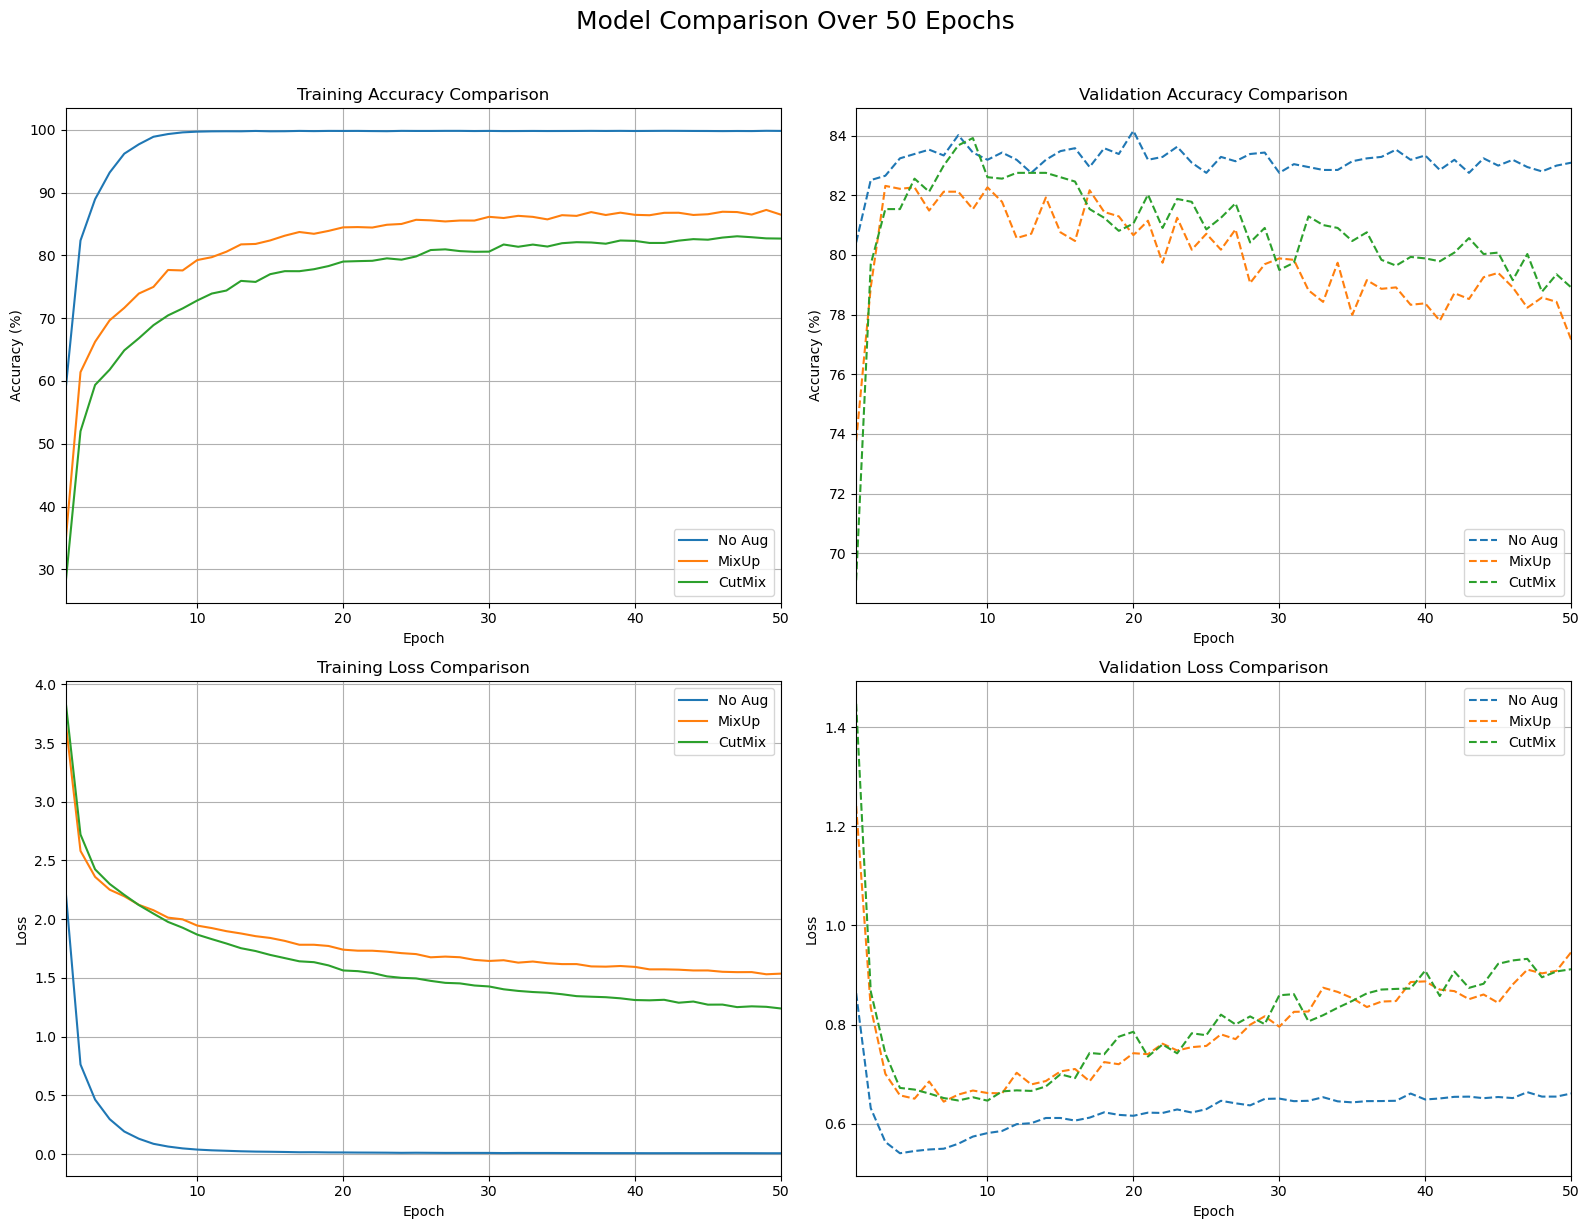

In [33]:
history_no_aug = load_history_from_checkpoint('no_aug')
history_aug = load_history_from_checkpoint('base_aug')
history_mixup = load_history_from_checkpoint('mixup')
history_cutmix = load_history_from_checkpoint('cutmix')

history_list = [history_no_aug, history_aug, history_mixup, history_cutmix]
labels_list = ['No Aug', 'Base Aug', 'MixUp', 'CutMix']

plot_history_v2(history_list, labels_list, EPOCH)